# Import Libraries

In [ ]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

# Check for GPU

In [1]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Define Custom Dataset

In [2]:
# Custom Dataset class for loading images and masks from nested folders
class TumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Collect image file paths from subdirectories
        self.image_files = []
        for patient_folder in os.listdir(self.root_dir):
            patient_path = os.path.join(self.root_dir, patient_folder)
            if os.path.isdir(patient_path):  # Check if it's a folder
                for file in os.listdir(patient_path):
                    if file.endswith(".tif") and not file.endswith("_mask.tif"):
                        self.image_files.append(os.path.join(patient_path, file))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        # Generate the corresponding mask path by replacing the file name
        mask_path = image_path.replace(".tif", "_mask.tif")

        # Load the image and mask
        image = Image.open(image_path).convert("L")  # Convert image to grayscale
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale

        # Apply the transformations (resize, convert to tensor, etc.)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define Image Transformations

In [ ]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images to 256x256
    transforms.ToTensor(),          # Convert image to tensor
])

# Define Dataset and DataLoaders

In [ ]:
# Instantiate the dataset
dataset = TumorDataset(root_dir='lgg-mri-segmentation', transform=transform)

# Define sizes for the splits
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Perform the splits
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the number of samples
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Testing samples: {len(test_dataset)}")

Training samples: 2750, Validation samples: 589, Testing samples: 590


# Define Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder (Downsampling)
        self.conv1 = self.conv_block(1, 64)
        self.conv2 = self.conv_block(64, 128)
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 512)

        # Bottleneck
        self.conv5 = self.conv_block(512, 1024)

        # Decoder (Upsampling)
        self.upconv4 = self.upconv_block(1024, 512)
        self.upconv3 = self.upconv_block(512, 256)
        self.upconv2 = self.upconv_block(256, 128)
        self.upconv1 = self.upconv_block(128, 64)

        # Final Convolution
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        x1 = self.conv1(x)  # 64x64
        x2 = self.conv2(x1)  # 128x128
        x3 = self.conv3(x2)  # 256x256
        x4 = self.conv4(x3)  # 512x512

        # Bottleneck
        x5 = self.conv5(x4)  # 1024x1024

        # Decoder
        x = self.upconv4(x5)
        x = self.upconv3(x + x4)  # skip connection
        x = self.upconv2(x + x3)  # skip connection
        x = self.upconv1(x + x2)  # skip connection

        # Final output
        x = self.final_conv(x + x1)  # skip connection
        return torch.sigmoid(x)  # Using sigmoid for binary segmentation

# Instantiate the model
model = UNet().to(device)

# Train Model

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

# Define a function to calculate the Dice score
def dice_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()  # Convert predictions to binary mask
    intersection = (preds * targets).sum()
    dice = (2.0 * intersection) / (preds.sum() + targets.sum() + 1e-7)  # Adding epsilon to avoid division by zero
    return dice.item()

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop with validation
num_epochs = 50
best_val_loss = np.inf  # Initialize with infinity for tracking the best model

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_dice = 0.0  # Track Dice score

    # Add tqdm progress bar for the training loop
    train_loader_tqdm = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", leave=True)
    for images, masks in train_loader_tqdm:
        images = images.to(device).float()
        masks = masks.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)
        outputs = F.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_dice += dice_score(outputs, masks)  # Calculate Dice score for the batch

        # Update tqdm with running loss and Dice score
        train_loader_tqdm.set_postfix({'Train Loss': running_loss / len(train_loader),
                                       'Train Dice': running_dice / len(train_loader)})

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_dice = 0.0  # Track validation Dice score

    val_loader_tqdm = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", leave=True)
    with torch.no_grad():
        for images, masks in val_loader_tqdm:
            images = images.to(device).float()
            masks = masks.to(device).float()

            outputs = model(images)
            outputs = F.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_dice += dice_score(outputs, masks)  # Calculate Dice score for validation batch

            # Update tqdm with validation loss and Dice score
            val_loader_tqdm.set_postfix({'Val Loss': val_loss / len(val_loader),
                                         'Val Dice': val_dice / len(val_loader)})

    # After the epoch finishes, print the final loss and Dice score
    avg_train_loss = running_loss / len(train_loader)
    avg_train_dice = running_dice / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)

    tqdm.write(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}, '
               f'Val Loss: {avg_val_loss:.4f}, Val Dice: {avg_val_dice:.4f}')

    # Check if this is the best model so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model_unet.pth')  # Save the model

print("Finished Training!")

Validation Epoch 1/50: 100%|██████████| 74/74 [00:09<00:00,  7.69it/s, Val Loss=0.0376, Val Dice=0] 


Epoch [1/50], Train Loss: 0.0850, Train Dice: 0.0002, Val Loss: 0.0376, Val Dice: 0.0000


Validation Epoch 2/50: 100%|██████████| 74/74 [00:06<00:00, 11.18it/s, Val Loss=0.0354, Val Dice=0] 


Epoch [2/50], Train Loss: 0.0371, Train Dice: 0.0000, Val Loss: 0.0354, Val Dice: 0.0000


Validation Epoch 3/50: 100%|██████████| 74/74 [00:06<00:00, 11.25it/s, Val Loss=0.0317, Val Dice=0.055]   


Epoch [3/50], Train Loss: 0.0345, Train Dice: 0.1422, Val Loss: 0.0317, Val Dice: 0.0550


Validation Epoch 4/50: 100%|██████████| 74/74 [00:03<00:00, 18.73it/s, Val Loss=0.0313, Val Dice=0.13]    


Epoch [4/50], Train Loss: 0.0348, Train Dice: 0.1207, Val Loss: 0.0313, Val Dice: 0.1300


Validation Epoch 5/50: 100%|██████████| 74/74 [00:03<00:00, 20.90it/s, Val Loss=0.032, Val Dice=0.27]    


Epoch [5/50], Train Loss: 0.0327, Train Dice: 0.1812, Val Loss: 0.0320, Val Dice: 0.2705


Validation Epoch 6/50: 100%|██████████| 74/74 [00:03<00:00, 22.83it/s, Val Loss=0.0315, Val Dice=0.254]  


Epoch [6/50], Train Loss: 0.0299, Train Dice: 0.2660, Val Loss: 0.0315, Val Dice: 0.2543


Validation Epoch 7/50: 100%|██████████| 74/74 [00:03<00:00, 22.91it/s, Val Loss=0.0287, Val Dice=0.308]  


Epoch [7/50], Train Loss: 0.0293, Train Dice: 0.2777, Val Loss: 0.0287, Val Dice: 0.3079


Validation Epoch 8/50: 100%|██████████| 74/74 [00:03<00:00, 20.91it/s, Val Loss=0.0264, Val Dice=0.365]  


Epoch [8/50], Train Loss: 0.0268, Train Dice: 0.3296, Val Loss: 0.0264, Val Dice: 0.3651


Validation Epoch 9/50: 100%|██████████| 74/74 [00:03<00:00, 21.04it/s, Val Loss=0.0261, Val Dice=0.368]  


Epoch [9/50], Train Loss: 0.0255, Train Dice: 0.3441, Val Loss: 0.0261, Val Dice: 0.3683


Validation Epoch 10/50: 100%|██████████| 74/74 [00:03<00:00, 21.06it/s, Val Loss=0.023, Val Dice=0.307]   


Epoch [10/50], Train Loss: 0.0236, Train Dice: 0.3730, Val Loss: 0.0230, Val Dice: 0.3074


Validation Epoch 11/50: 100%|██████████| 74/74 [00:03<00:00, 21.62it/s, Val Loss=0.0232, Val Dice=0.329]  


Epoch [11/50], Train Loss: 0.0218, Train Dice: 0.4083, Val Loss: 0.0232, Val Dice: 0.3290


Validation Epoch 12/50: 100%|██████████| 74/74 [00:03<00:00, 22.47it/s, Val Loss=0.0363, Val Dice=0] 


Epoch [12/50], Train Loss: 0.0329, Train Dice: 0.1659, Val Loss: 0.0363, Val Dice: 0.0000


Validation Epoch 13/50: 100%|██████████| 74/74 [00:02<00:00, 24.82it/s, Val Loss=0.0326, Val Dice=0.0677]  


Epoch [13/50], Train Loss: 0.0341, Train Dice: 0.0216, Val Loss: 0.0326, Val Dice: 0.0677


Validation Epoch 14/50: 100%|██████████| 74/74 [00:03<00:00, 20.92it/s, Val Loss=0.0323, Val Dice=0.21]   


Epoch [14/50], Train Loss: 0.0317, Train Dice: 0.2189, Val Loss: 0.0323, Val Dice: 0.2100


Validation Epoch 15/50: 100%|██████████| 74/74 [00:03<00:00, 20.93it/s, Val Loss=0.0236, Val Dice=0.353]  


Epoch [15/50], Train Loss: 0.0272, Train Dice: 0.3385, Val Loss: 0.0236, Val Dice: 0.3531


Validation Epoch 16/50: 100%|██████████| 74/74 [00:03<00:00, 22.68it/s, Val Loss=0.0253, Val Dice=0.408]  


Epoch [16/50], Train Loss: 0.0242, Train Dice: 0.3547, Val Loss: 0.0253, Val Dice: 0.4078


Validation Epoch 17/50: 100%|██████████| 74/74 [00:03<00:00, 21.13it/s, Val Loss=0.0185, Val Dice=0.471]  


Epoch [17/50], Train Loss: 0.0203, Train Dice: 0.4416, Val Loss: 0.0185, Val Dice: 0.4710


Validation Epoch 18/50: 100%|██████████| 74/74 [00:03<00:00, 22.29it/s, Val Loss=0.0168, Val Dice=0.475]  


Epoch [18/50], Train Loss: 0.0173, Train Dice: 0.5442, Val Loss: 0.0168, Val Dice: 0.4748


Validation Epoch 19/50: 100%|██████████| 74/74 [00:03<00:00, 22.50it/s, Val Loss=0.0153, Val Dice=0.559]  


Epoch [19/50], Train Loss: 0.0148, Train Dice: 0.6016, Val Loss: 0.0153, Val Dice: 0.5594


Validation Epoch 20/50: 100%|██████████| 74/74 [00:03<00:00, 21.91it/s, Val Loss=0.0138, Val Dice=0.635]  


Epoch [20/50], Train Loss: 0.0130, Train Dice: 0.6265, Val Loss: 0.0138, Val Dice: 0.6355


Validation Epoch 21/50: 100%|██████████| 74/74 [00:03<00:00, 22.20it/s, Val Loss=0.0151, Val Dice=0.534]  


Epoch [21/50], Train Loss: 0.0123, Train Dice: 0.6790, Val Loss: 0.0151, Val Dice: 0.5338


Validation Epoch 22/50: 100%|██████████| 74/74 [00:03<00:00, 22.36it/s, Val Loss=0.0162, Val Dice=0.624]  


Epoch [22/50], Train Loss: 0.0105, Train Dice: 0.7062, Val Loss: 0.0162, Val Dice: 0.6238


Validation Epoch 23/50: 100%|██████████| 74/74 [00:03<00:00, 21.59it/s, Val Loss=0.0124, Val Dice=0.655]  


Epoch [23/50], Train Loss: 0.0097, Train Dice: 0.7516, Val Loss: 0.0124, Val Dice: 0.6553


Validation Epoch 24/50: 100%|██████████| 74/74 [00:03<00:00, 21.06it/s, Val Loss=0.0111, Val Dice=0.684]  


Epoch [24/50], Train Loss: 0.0105, Train Dice: 0.7186, Val Loss: 0.0111, Val Dice: 0.6840


Validation Epoch 25/50: 100%|██████████| 74/74 [00:03<00:00, 20.61it/s, Val Loss=0.0115, Val Dice=0.641]  


Epoch [25/50], Train Loss: 0.0083, Train Dice: 0.7503, Val Loss: 0.0115, Val Dice: 0.6414


Validation Epoch 26/50: 100%|██████████| 74/74 [00:03<00:00, 21.04it/s, Val Loss=0.0104, Val Dice=0.696]  


Epoch [26/50], Train Loss: 0.0078, Train Dice: 0.7719, Val Loss: 0.0104, Val Dice: 0.6963


Validation Epoch 27/50: 100%|██████████| 74/74 [00:03<00:00, 20.89it/s, Val Loss=0.0112, Val Dice=0.685]  


Epoch [27/50], Train Loss: 0.0076, Train Dice: 0.7746, Val Loss: 0.0112, Val Dice: 0.6854


Validation Epoch 28/50: 100%|██████████| 74/74 [00:03<00:00, 21.06it/s, Val Loss=0.0106, Val Dice=0.709]  


Epoch [28/50], Train Loss: 0.0079, Train Dice: 0.7592, Val Loss: 0.0106, Val Dice: 0.7094


Validation Epoch 29/50: 100%|██████████| 74/74 [00:03<00:00, 22.88it/s, Val Loss=0.00984, Val Dice=0.719] 


Epoch [29/50], Train Loss: 0.0064, Train Dice: 0.8060, Val Loss: 0.0098, Val Dice: 0.7195


Validation Epoch 30/50: 100%|██████████| 74/74 [00:03<00:00, 22.27it/s, Val Loss=0.0109, Val Dice=0.666]  


Epoch [30/50], Train Loss: 0.0066, Train Dice: 0.8043, Val Loss: 0.0109, Val Dice: 0.6663


Validation Epoch 31/50: 100%|██████████| 74/74 [00:02<00:00, 24.71it/s, Val Loss=0.0122, Val Dice=0.665]  


Epoch [31/50], Train Loss: 0.0061, Train Dice: 0.8037, Val Loss: 0.0122, Val Dice: 0.6654


Validation Epoch 32/50: 100%|██████████| 74/74 [00:02<00:00, 24.78it/s, Val Loss=0.0283, Val Dice=0.00416] 


Epoch [32/50], Train Loss: 0.0245, Train Dice: 0.2840, Val Loss: 0.0283, Val Dice: 0.0042


Validation Epoch 33/50: 100%|██████████| 74/74 [00:02<00:00, 24.89it/s, Val Loss=0.0127, Val Dice=0.654]  


Epoch [33/50], Train Loss: 0.0172, Train Dice: 0.4937, Val Loss: 0.0127, Val Dice: 0.6539


Validation Epoch 34/50: 100%|██████████| 74/74 [00:02<00:00, 24.75it/s, Val Loss=0.0094, Val Dice=0.704]  


Epoch [34/50], Train Loss: 0.0080, Train Dice: 0.7575, Val Loss: 0.0094, Val Dice: 0.7041


Validation Epoch 35/50: 100%|██████████| 74/74 [00:02<00:00, 24.83it/s, Val Loss=0.00919, Val Dice=0.725] 


Epoch [35/50], Train Loss: 0.0065, Train Dice: 0.7992, Val Loss: 0.0092, Val Dice: 0.7246


Validation Epoch 36/50: 100%|██████████| 74/74 [00:03<00:00, 24.61it/s, Val Loss=0.0103, Val Dice=0.719]  


Epoch [36/50], Train Loss: 0.0054, Train Dice: 0.8416, Val Loss: 0.0103, Val Dice: 0.7192


Validation Epoch 37/50: 100%|██████████| 74/74 [00:02<00:00, 24.81it/s, Val Loss=0.0092, Val Dice=0.724]  


Epoch [37/50], Train Loss: 0.0050, Train Dice: 0.8393, Val Loss: 0.0092, Val Dice: 0.7244


Validation Epoch 38/50: 100%|██████████| 74/74 [00:03<00:00, 20.69it/s, Val Loss=0.00997, Val Dice=0.714] 


Epoch [38/50], Train Loss: 0.0050, Train Dice: 0.8382, Val Loss: 0.0100, Val Dice: 0.7142


Validation Epoch 39/50: 100%|██████████| 74/74 [00:03<00:00, 20.88it/s, Val Loss=0.0103, Val Dice=0.728]  


Epoch [39/50], Train Loss: 0.0048, Train Dice: 0.8401, Val Loss: 0.0103, Val Dice: 0.7276


Validation Epoch 40/50: 100%|██████████| 74/74 [00:03<00:00, 20.89it/s, Val Loss=0.0105, Val Dice=0.722]  


Epoch [40/50], Train Loss: 0.0050, Train Dice: 0.8487, Val Loss: 0.0105, Val Dice: 0.7217


Validation Epoch 41/50: 100%|██████████| 74/74 [00:03<00:00, 20.98it/s, Val Loss=0.0109, Val Dice=0.708]  


Epoch [41/50], Train Loss: 0.0046, Train Dice: 0.8466, Val Loss: 0.0109, Val Dice: 0.7080


Validation Epoch 42/50: 100%|██████████| 74/74 [00:03<00:00, 21.08it/s, Val Loss=0.0111, Val Dice=0.723]  


Epoch [42/50], Train Loss: 0.0049, Train Dice: 0.8268, Val Loss: 0.0111, Val Dice: 0.7227


Validation Epoch 43/50: 100%|██████████| 74/74 [00:03<00:00, 20.83it/s, Val Loss=0.011, Val Dice=0.727]   


Epoch [43/50], Train Loss: 0.0041, Train Dice: 0.8567, Val Loss: 0.0110, Val Dice: 0.7266


Validation Epoch 44/50: 100%|██████████| 74/74 [00:03<00:00, 20.86it/s, Val Loss=0.0105, Val Dice=0.732]  


Epoch [44/50], Train Loss: 0.0038, Train Dice: 0.8710, Val Loss: 0.0105, Val Dice: 0.7317


Validation Epoch 45/50: 100%|██████████| 74/74 [00:03<00:00, 20.87it/s, Val Loss=0.0181, Val Dice=0.537]  


Epoch [45/50], Train Loss: 0.0083, Train Dice: 0.7513, Val Loss: 0.0181, Val Dice: 0.5370


Validation Epoch 46/50: 100%|██████████| 74/74 [00:03<00:00, 21.14it/s, Val Loss=0.0108, Val Dice=0.716]  


Epoch [46/50], Train Loss: 0.0092, Train Dice: 0.7417, Val Loss: 0.0108, Val Dice: 0.7161


Validation Epoch 47/50: 100%|██████████| 74/74 [00:03<00:00, 20.82it/s, Val Loss=0.0102, Val Dice=0.739]  


Epoch [47/50], Train Loss: 0.0046, Train Dice: 0.8614, Val Loss: 0.0102, Val Dice: 0.7391


Validation Epoch 48/50: 100%|██████████| 74/74 [00:02<00:00, 24.91it/s, Val Loss=0.00984, Val Dice=0.735] 


Epoch [48/50], Train Loss: 0.0039, Train Dice: 0.8698, Val Loss: 0.0098, Val Dice: 0.7353


Validation Epoch 49/50: 100%|██████████| 74/74 [00:02<00:00, 24.75it/s, Val Loss=0.0108, Val Dice=0.746]  


Epoch [49/50], Train Loss: 0.0036, Train Dice: 0.8798, Val Loss: 0.0108, Val Dice: 0.7460


Validation Epoch 50/50: 100%|██████████| 74/74 [00:02<00:00, 24.74it/s, Val Loss=0.0115, Val Dice=0.728]  

Epoch [50/50], Train Loss: 0.0034, Train Dice: 0.8746, Val Loss: 0.0115, Val Dice: 0.7276
Finished Training!


# Evaluate Model

In [11]:
# Loading the best model
print("Loading the best model for testing...")
model.load_state_dict(torch.load('best_model_unet.pth'))

# Testing loop
print("Testing the model...")
model.eval()
test_loss = 0.0
test_dice = 0.0

test_loader_tqdm = tqdm(test_loader, desc="Testing", leave=True)
with torch.no_grad():
    for images, masks in test_loader_tqdm:
        images = images.to(device).float()
        masks = masks.to(device).float()

        outputs = model(images)
        outputs = F.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)
        loss = criterion(outputs, masks)
        test_loss += loss.item()
        test_dice += dice_score(outputs, masks)  # Calculate Dice score for the test batch

        # Update tqdm with test loss and Dice score
        test_loader_tqdm.set_postfix({'Test Loss': test_loss / len(test_loader),
                                      'Test Dice': test_dice / len(test_loader)})

# Calculate the average test loss and Dice score
avg_test_loss = test_loss / len(test_loader)
avg_test_dice = test_dice / len(test_loader)

print(f'Test Loss: {avg_test_loss:.4f}, Test Dice: {avg_test_dice:.4f}')

C:\Users\202138114\AppData\Local\Temp\ipykernel_15616\3926434141.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_unet.pth'))

Loading the best model for testing...
Testing the model...


Testing: 100%|██████████| 74/74 [00:06<00:00, 12.29it/s, Test Loss=0.00971, Test Dice=0.741] 

Test Loss: 0.0097, Test Dice: 0.7411


# Visualize Results

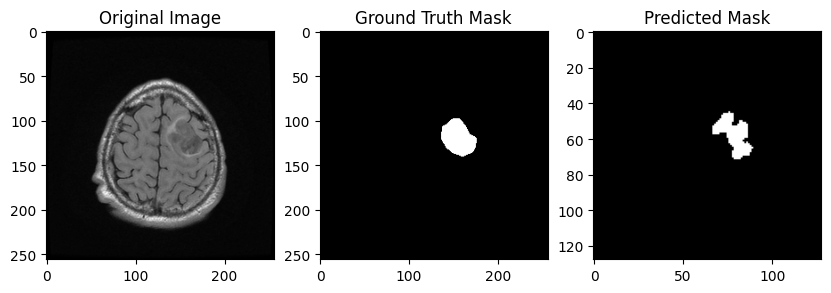

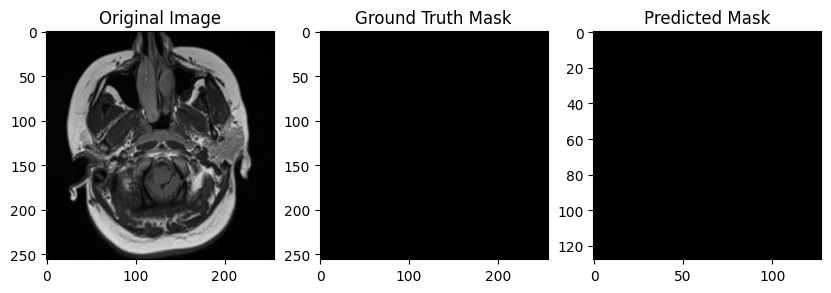

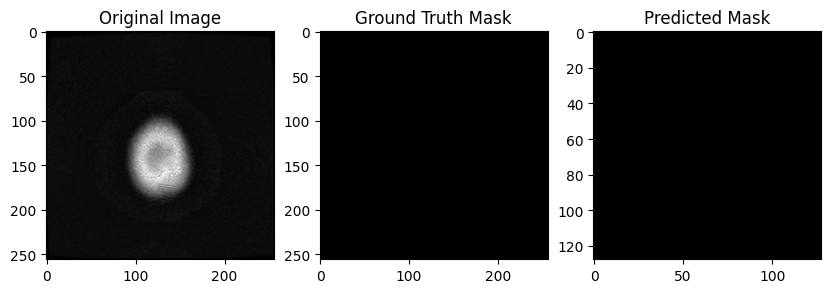

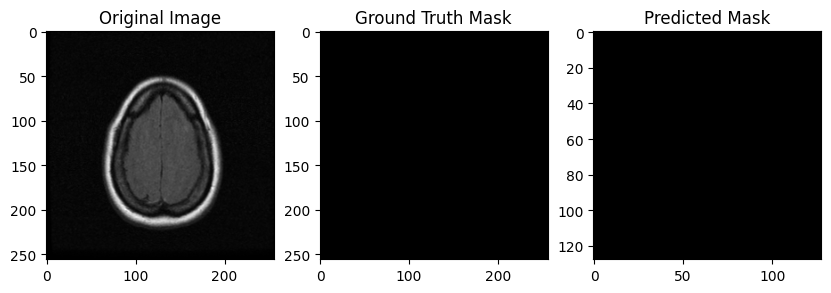

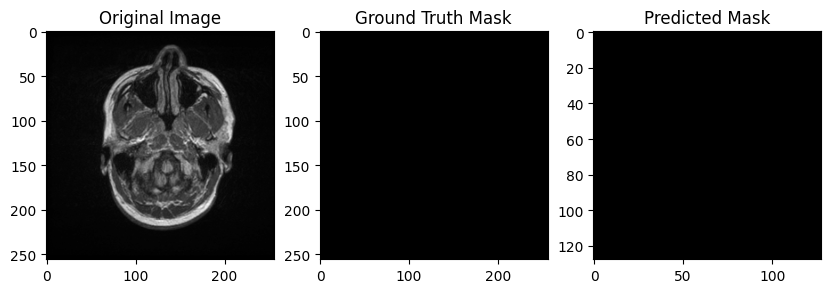

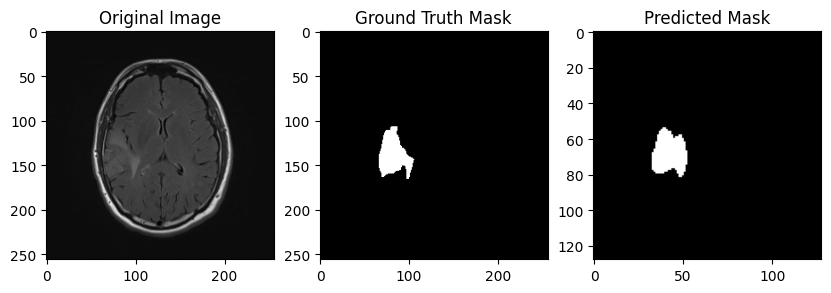

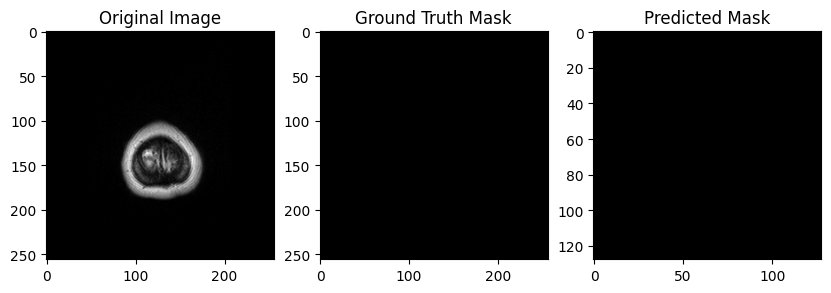

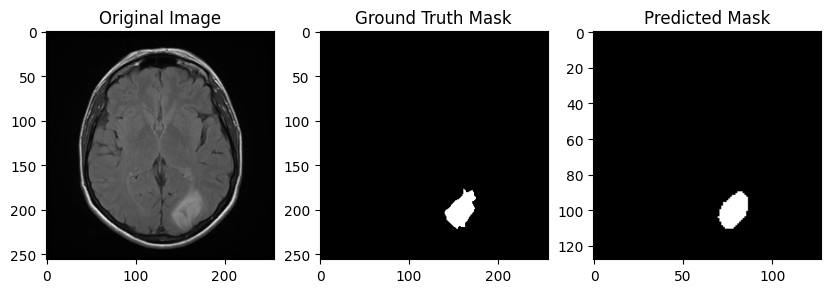

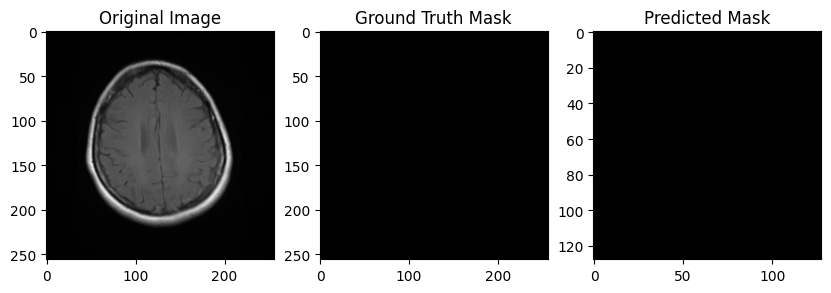

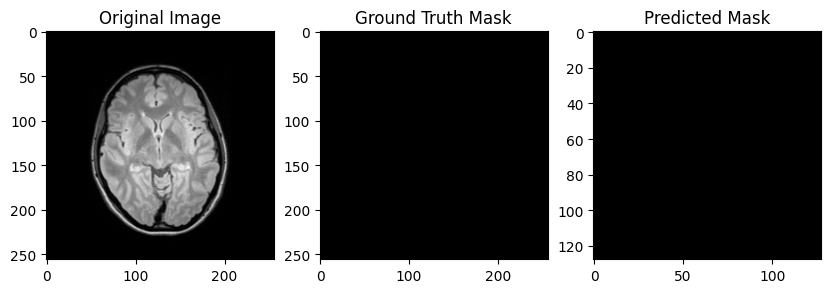

In [12]:
import matplotlib.pyplot as plt

model.eval()  # Set the model to evaluation mode
num_samples = 10  # Number of samples to display
sample_count = 0  # Counter to keep track of displayed samples

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device).float()
        masks = masks.to(device).float()

        outputs = model(images)
        outputs = (outputs > 0.5).float()  # Convert to binary mask (0 or 1)

        batch_size = images.size(0)  # Current batch size
        for i in range(batch_size):
            if sample_count >= num_samples:
                break  # Stop once we have displayed the required number of samples

            plt.figure(figsize=(10, 5))

            # Original image
            plt.subplot(1, 3, 1)
            plt.imshow(images[i].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
            plt.title("Original Image")

            # Ground truth mask
            plt.subplot(1, 3, 2)
            plt.imshow(masks[i].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
            plt.title("Ground Truth Mask")

            # Predicted mask
            plt.subplot(1, 3, 3)
            plt.imshow(outputs[i].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
            plt.title("Predicted Mask")

            plt.show()

            sample_count += 1
        if sample_count >= num_samples:
            break  # Stop outer loop if we have enough samples